
# Project 1



The following code is the formulation given by the professor, After this one is a formulation by me using variable thrust and motor gimble. 

[1] loss: 9.426
[2] loss: 8.041
[3] loss: 7.079
[4] loss: 6.391
[5] loss: 5.789
[6] loss: 5.128
[7] loss: 4.152
[8] loss: 2.781
[9] loss: 1.615
[10] loss: 1.000
[11] loss: 0.718
[12] loss: 0.547
[13] loss: 0.435
[14] loss: 0.358
[15] loss: 0.303
[16] loss: 0.265
[17] loss: 0.238
[18] loss: 0.219
[19] loss: 0.206
[20] loss: 0.197
[21] loss: 0.191
[22] loss: 0.187
[23] loss: 0.184
[24] loss: 0.182
[25] loss: 0.181
[26] loss: 0.180
[27] loss: 0.179
[28] loss: 0.179
[29] loss: 0.179
[30] loss: 0.179
[31] loss: 0.179
[32] loss: 0.179
[33] loss: 0.179
[34] loss: 0.180
[35] loss: 0.180
[36] loss: 0.181
[37] loss: 0.183
[38] loss: 0.187
[39] loss: 0.185
[40] loss: 0.182
[41] loss: 0.175
[42] loss: 0.157
[43] loss: 0.138
[44] loss: 0.126
[45] loss: 0.115
[46] loss: 0.117
[47] loss: 0.123
[48] loss: 0.124
[49] loss: 0.121
[50] loss: 0.111


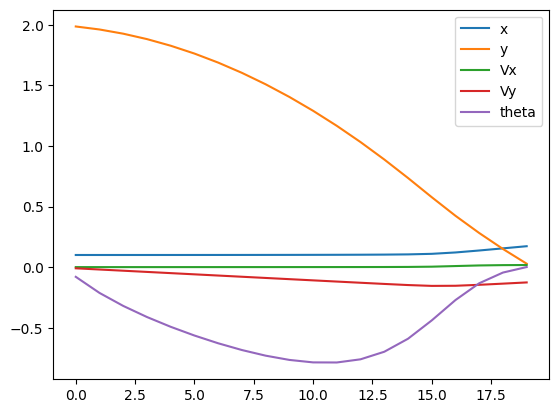

In [199]:

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
t.manual_seed(0)

# environment parameters

FRAME_TIME = 1  # time interval
GRAVITY_ACCEL = 0.01  # gravity constant
BOOST_ACCEL = 0.02  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        
        '''
        action[0] = Thrust
        action[1] = change in theta
        state[0] = x
        state[1] = y
        state[2] = Vx
        state[3] = Vy
        state[4] = theta
        '''
        
        # gravity tensor, only affects the second state
        delta_state_gravity = - GRAVITY_ACCEL * t.tensor([0., 0.5 * FRAME_TIME**2, 0., FRAME_TIME, 0.])

        # first action tensor
        sin_value = t.sin(state[4])
        cos_value = t.cos(state[4])

        state_tensor = t.tensor([-0.5 * (FRAME_TIME ** 2) * sin_value,
                                    0.5 * (FRAME_TIME ** 2) * cos_value,
                                    -FRAME_TIME * sin_value,
                                    FRAME_TIME * cos_value,
                                    0.])

        delta_state = BOOST_ACCEL * t.mul(state_tensor,action[0])

        # Second action tensor
        delta_state_theta = t.mul(t.tensor([0., 0., 0., 0., 1.]), (np.pi/4)*(2*action[1] - 1))

        # update state
        state = state + delta_state + delta_state_gravity + delta_state_theta

        # step forward
        step_mat = t.tensor([[1., 0., FRAME_TIME, 0., 0.],
                             [0., 1., 0., FRAME_TIME, 0.],
                             [0., 0., 1., 0., 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat,state)
        
        return state

# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0.1,2.,0.,0.,0.1]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        weights = t.tensor([1.,1.,1.,5.,10.])
        return t.matmul(weights.T,t.square(state))

# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.plot(data[:, 0],label='x')
        plt.plot(data[:, 1],label='y')
        plt.plot(data[:, 2],label='Vx')
        plt.plot(data[:, 3],label='Vy')
        plt.plot(data[:, 4],label='theta')
        plt.legend()
        plt.show()

# Now it's time to run the code!

T = 20  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 12 # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem



### Formulation of Rocket with gimble and variable thrust

Let the state space be $ X = \left[ x,y,\theta,V_x,V_y,\omega \right]^T$

where $x$ and $y$ are distance, $V_x$ and $V_y$ are Velocities, $\theta$ is the orientation, and $\omega$ is angular velocity. 

Let the action variables be $ A = \left[ F_T, \beta\right]$

where $F_T$ is the variable thrust and $\beta$ is the gimble angle of the motor. 

Define $ \gamma = \theta + \beta$

![h function](Formulation1.png)

From the above diagram we can write continous non linear dynamics in state space form: 

\begin{equation*}
            \begin{bmatrix}
                x_1 \hspace{.2cm}
                x_2 \hspace{.2cm}
                x_3 \hspace{.2cm}
                x_4 \hspace{.2cm}
                x_5 \hspace{.2cm}
                x_6
            \end{bmatrix}^T
            =
            \begin{bmatrix}
                x \hspace{.2cm}
                y\hspace{.2cm}
                \theta\hspace{.2cm}
                \dot{x}\hspace{.2cm}
                \dot{y}\hspace{.2cm}
                \dot{\theta}
            \end{bmatrix}^T
            
\end{equation*}

\begin{equation*}
            \begin{bmatrix}
                \dot{x_1} \\
                \dot{x_2} \\
                \dot{x_3} \\
                \dot{x_4} \\
                \dot{x_5} \\
                \dot{x_6} \\
            \end{bmatrix}
            =
            \begin{bmatrix}
                \dot{x} \\
                \dot{y} \\
                \dot{\theta} \\
                \ddot{x} \\
                \ddot{y} \\
                \ddot{\theta} \\
            \end{bmatrix}
            = 
            \begin{bmatrix}
                x_4\\
                x_5 \\
                x_6 \\
                \frac{-F_T \sin(x_3 + \beta)}{m} \\
                \frac{F_T \cos(x_3 + \beta)}{m} - g \\ 
                \frac{- 12 F_T \sin(\beta) }{ml^2}\\ 
            \end{bmatrix}
\end{equation*}

Discretize the state space: 

\begin{equation*}
            \begin{bmatrix}
                x_1 \\
                x_2 \\
                x_3 \\
                x_4 \\
                x_5 \\
                x_6 \\
            \end{bmatrix}_{k+1}
            = 
            \begin{bmatrix}
                x_1 + T_s x_4 \\
                x_2 + T_s x_5 \\
                x_3 + T_s x_6 \\
                x_4 + T_s\left(\frac{-F_T \sin(x_3 + \beta)}{m}\right) \\
                x_5 + T_s\left(\frac{F_T \cos(x_3 + \beta)}{m} - g\right) \\ 
                x_6 + T_s\left(\frac{- 12 F_T \sin(\beta) }{ml^2}\right)\\ 
            \end{bmatrix}_k
\end{equation*}

Now the code:

[1] loss: 5667.046
[2] loss: 3687.569
[3] loss: 2297.015
[4] loss: 758.828
[5] loss: 564.523
[6] loss: 373.274
[7] loss: 180.199
[8] loss: 134.442
[9] loss: 101.958
[10] loss: 76.799
[11] loss: 56.809
[12] loss: 40.125
[13] loss: 26.098
[14] loss: 17.007
[15] loss: 11.614
[16] loss: 8.159
[17] loss: 5.682
[18] loss: 3.772
[19] loss: 2.410
[20] loss: 1.572
[21] loss: 1.073
[22] loss: 0.734
[23] loss: 0.520
[24] loss: 0.383
[25] loss: 0.301
[26] loss: 0.259
[27] loss: 0.235
[28] loss: 0.216
[29] loss: 0.207
[30] loss: 0.203
[31] loss: 0.198
[32] loss: 0.128
[33] loss: 0.102
[34] loss: 0.088
[35] loss: 0.084
[36] loss: 0.083
[37] loss: 0.082
[38] loss: 0.079
[39] loss: 0.077
[40] loss: 0.074


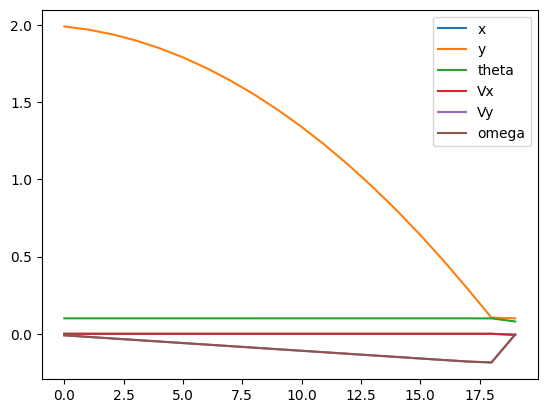

In [200]:
FRAME_TIME = 1  # time interval

t.manual_seed(0) # Fix the randomness of the 
m = 2 # Rocket mass
g = 0.01 # Gravity, This is not realistic but functional
l = 2 # Rocket length


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        
        '''
        action[0] = Thrust
        action[1] = gimble angle
        state[0] = x
        state[1] = y
        state[2] = theta
        state[3] = Vx
        state[4] = Vy
        state[5] = omega
        '''
        
        # Non linear terms for second order differential equations
        sin_value_gamma = t.sin(state[3] + (np.pi/3)*(2*action[1] - 1))
        cos_value_gamma = t.cos(state[3] + (np.pi/3)*(2*action[1] - 1))
        sin_value_beta = t.sin((np.pi/3)*(2*action[1] - 1))
        
        # tensor for non linear terms of equations
        delta_state = FRAME_TIME * (action[0]/m) * t.tensor([0.,
                                                             0., 
                                                             0., 
                                                             -sin_value_gamma, 
                                                             cos_value_gamma, 
                                                             -12/(l**2) * sin_value_beta])

        # Gravity tensor
        delta_state_gravity = FRAME_TIME * t.tensor([0.,0.,0.,0.,-g,0.])

        # update state
        state = state + delta_state + delta_state_gravity

        # step forward
        step_mat = t.tensor([[1., 0., 0., FRAME_TIME, 0., 0.],
                             [0., 1., 0., 0., FRAME_TIME, 0.],
                             [0., 0., 1., 0., 0., FRAME_TIME],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat,state)
    
        return state

# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0.,2.,0.1,0.,0.,0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        weights = t.tensor([1.,1.,10.,1.,5.,1.])
        return t.matmul(weights.T,t.square(state))

# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.plot(data[:, 0],label='x')
        plt.plot(data[:, 1],label='y')
        plt.plot(data[:, 2],label='theta')
        plt.plot(data[:, 3],label='Vx')
        plt.plot(data[:, 4],label='Vy')
        plt.plot(data[:, 4],label='omega')
        plt.legend()
        plt.show()

# Now it's time to run the code!

T = 20 # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 10 # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

### Analysis of the results. 

For both formulations, the large x value in the intial condition moves towards zero, and other specified intial conditions diverge slightly, converge to zero, or stay they same for duration of the trajectory. All in all every tends to be near zero at the end of total time of flight. The new formulation introduces a new way of controlling the rocket by allowing the thrust force to act in various directions. We have a magnitude and angle. This is comparable to having two actions that are the components of the thrust force. Both of the formulations were difficult to find good parameters for convergence. This is why chose simple indital conditions to show that the controller can converge.

It would be quite difficult based on my experience with this project to get this controller for both formulations to be generalizable because a slight change in inditial conditions would bring great divergence. 

If I continue to work on this project, I intend to add a drag force that is proportional to the square of the velocity. The direction will be oppisite to velocity. I will add it to the rocket with gimble formulation. 

